# <center><font color = 'blue'>*ADRIS MISRA*</font></center>

**Github repository:** https://github.com/GreatLearningAIML1/gl-pgp-aiml-uta-intl-aug20-adris-misra

# Project -  Plant's Seeding Species Classification

### Context:
- Can you differentiate a weed from a crop seedling?
- The ability to do so effectively can mean better crop yields and better stewardship of the environment.
- The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has recently released a dataset containing images of unique plants belonging to 12 species at several growth stages

### Objective:
To implement the techniques learnt as a part of the course.

### Learning Outcomes:
- Pre-processing of image data.
- Visualization of images.
- Building CNN.
- Evaluate the Model.

### Data Description:
You are provided with a training set and a test set of images of plant seedlings at various stages of grown. Each image has a filename that is its unique id. The dataset comprises 12 plant species. The goal of the competition is to create a classifier capable of determining a plant's species from a photo.

### Dataset:
The project is from a dataset from Kaggle.
Link to the Kaggle project site: https://www.kaggle.com/c/plant-seedlings-classification/data
- Note: For project purposes, download only train images folder from Kaggle. (See note at the end of problem statement.)
The dataset has to be downloaded from the above Kaggle website.

## Steps and tasks:
1. Import the libraries, load dataset, print shape of data, visualize the images in dataset. (5 Marks)
2. Data Pre-processing: (15 Marks)<br>
  a. Normalization.<br>
  b. Gaussian Blurring.<br>
  c. Visualize data after pre-processing.
3. Make data compatible: (10 Marks)<br>
  a. Split the dataset into training, testing, and validation set.<br>
(Hint: First split train images and train labels into training and testing set with test_size = 0.3. Then further split test data into test and validation set with test_size = 0.5)<br>
[Read the note at the end of the problem statement for the reason behind using the train images for using for training and testing set.]<br>
  b. Reshape data into shapes compatible with Keras models.<br>
  c. Convert labels from digits to one hot vectors.<br>
  d. Print the label for y_train[0].<br>
4. Building CNN: (15 Marks)<br>
  a. Define layers.<br>
  b. Set optimizer and loss function. (Use Adam optimizer and categorical crossentropy.)<br>
5. Fit and evaluate model and print confusion matrix. (10 Marks)
6. Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]. (5 Marks)

### Note:
- Download the train images from the Kaggle dataset, don’t download the test images.
- As the test dataset is not labeled, so you won’t be able to calculate the accuracy score. So use train images and train labels only to split further into training and testing set during your model building.

In [1]:
# Import warnings to suppress runtime warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 7.1MB/s 


In [3]:
# Import Libraries

import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import seaborn as sns

from zipfile import ZipFile

import cv2
from google.colab.patches import cv2_imshow

from tensorflow.keras.models import Sequential, load_model  
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from kerastuner.tuners import RandomSearch
from kerastuner.tuners import Hyperband

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score,accuracy_score
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import os
from glob import glob
from pathlib import Path
import shutil

### Loading data of Image and preprocessing

In [ ]:
# Mapping google drive 

#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
# Set the path to the dataset folder. (The dataset contains three image folders: "predict", "test", and "train")

img_path = "/content/drive/My Drive/UTA/PGPAIML/CNN/SeedPredict/SeedClass.zip"
tgt_path = "/content/drive/My Drive/UTA/PGPAIML/CNN/SeedPredict/ImgData"
data_path = "/content/drive/My Drive/UTA/PGPAIML/CNN/SeedPredict/Data"

In [ ]:
# Extract the files from dataset, as the dataset is as zip file.

#with ZipFile(img_path, 'r') as zip:
#  zip.extractall(tgt_path)

In [ ]:
# Copy Imagedata from files
path = "/content/drive/My Drive/UTA/PGPAIML/CNN/SeedPredict/ImgData/*/*.png"                              # The path to all images in training set. (* means include all folders and files.)
files = glob(path)

trainImg = []                                              # Initialize empty list to store the image data as numbers.
trainLabel = []                                            # Initialize empty list to store the labels of images
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    '''
    Append the image data to trainImg list.
    Append the labels to trainLabel list.
    '''
    print(str(j) + "/" + str(num), end="\r")
    trainImg.append(cv2.resize(cv2.imread(img), (128, 128)))  # Get image (with resizing to 128x128)
    trainLabel.append(img.split('/')[-2])  # Get image label (folder name contains the class to which the image belong)
    j += 1

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

4750/4750


In [ ]:
# Saving to file for faster retrieval of data in future session disconnect

trainImg.dump(data_path+'/X_file')
trainLabel.to_csv(data_path+'/y_file.csv')

In [5]:
# Retrieve data from file when necessary

X = np.load(data_path+'/X_file', allow_pickle=True)
y = pd.read_csv(data_path+'/y_file.csv', index_col='Index')

y_label = y.copy()

In [6]:
# Check shape of the data

print(X.shape)
print(y.shape)

(4750, 128, 128, 3)
(4750, 1)


In [ ]:
# X data

X

array([[[[ 24,  47,  77],
         [ 33,  54,  81],
         [ 45,  66,  89],
         ...,
         [ 55,  78,  88],
         [ 60,  86,  94],
         [ 52,  83,  90]],

        [[ 21,  46,  79],
         [ 36,  57,  86],
         [ 46,  66,  90],
         ...,
         [ 59,  77,  88],
         [ 62,  81,  92],
         [ 57,  77,  89]],

        [[ 24,  49,  82],
         [ 31,  54,  84],
         [ 50,  69,  95],
         ...,
         [ 57,  72,  84],
         [ 58,  72,  85],
         [ 61,  77,  89]],

        ...,

        [[155, 149, 143],
         [156, 150, 144],
         [154, 149, 143],
         ...,
         [142, 136, 132],
         [ 97,  92,  91],
         [ 67,  61,  67]],

        [[155, 149, 142],
         [156, 150, 142],
         [152, 147, 141],
         ...,
         [140, 135, 130],
         [ 93,  87,  87],
         [ 60,  54,  59]],

        [[156, 149, 142],
         [155, 149, 141],
         [153, 147, 139],
         ...,
         [140, 133, 129],
        

In [ ]:
# Check class counts and percentages

df=pd.concat([y_label['label'].value_counts(),y_label['label'].value_counts(normalize=True)*100],axis=1)
df=df.reset_index()
df.columns=['seedling','count','frequency%']

df

,seedling,count,frequency%
0,Loose Silky-bent,654,13.768421
1,Common Chickweed,611,12.863158
2,Scentless Mayweed,516,10.863158
3,Small-flowered Cranesbill,496,10.442105
4,Fat Hen,475,10.000000
5,Charlock,390,8.210526
6,Sugar beet,385,8.105263
7,Cleavers,287,6.042105
8,Black-grass,263,5.536842
9,Shepherds Purse,231,4.863158


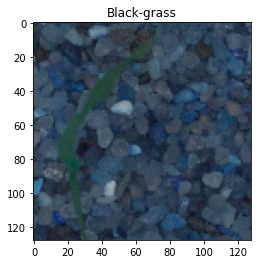

In [ ]:
# see image #1

ind = 1

plt.imshow(X[ind]);
plt.title(y_label.iloc[ind][0]);

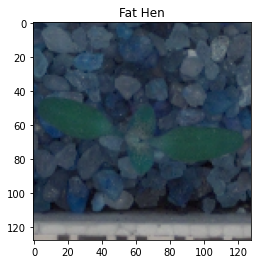

In [ ]:
# see image #2000

ind = 2000

plt.imshow(X[ind]);
plt.title(y_label.iloc[ind][0]);

In [7]:
# Normalization

X = X.astype('float32') # Conversion to float type from integer type.

X /= 255.0  # pixel value ranges from 0 - 255


In [ ]:
# Check X after normalization

X

array([[[[0.09411765, 0.18431373, 0.3019608 ],
         [0.12941177, 0.21176471, 0.31764707],
         [0.1764706 , 0.25882354, 0.34901962],
         ...,
         [0.21568628, 0.30588236, 0.34509805],
         [0.23529412, 0.3372549 , 0.36862746],
         [0.20392157, 0.3254902 , 0.3529412 ]],

        [[0.08235294, 0.18039216, 0.30980393],
         [0.14117648, 0.22352941, 0.3372549 ],
         [0.18039216, 0.25882354, 0.3529412 ],
         ...,
         [0.23137255, 0.3019608 , 0.34509805],
         [0.24313726, 0.31764707, 0.36078432],
         [0.22352941, 0.3019608 , 0.34901962]],

        [[0.09411765, 0.19215687, 0.32156864],
         [0.12156863, 0.21176471, 0.32941177],
         [0.19607843, 0.27058825, 0.37254903],
         ...,
         [0.22352941, 0.28235295, 0.32941177],
         [0.22745098, 0.28235295, 0.33333334],
         [0.23921569, 0.3019608 , 0.34901962]],

        ...,

        [[0.60784316, 0.58431375, 0.56078434],
         [0.6117647 , 0.5882353 , 0.5647059 ]

In [8]:
# Gaussian blurring of X with 15x15 filter

for idx, img in enumerate(X):
  X[idx] = cv2.GaussianBlur(img, (15, 15), 0)

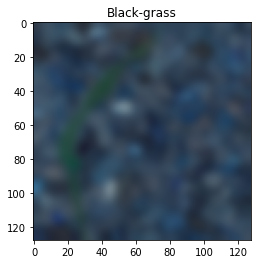

In [ ]:
# see image #1 after gaussian blur

ind = 1

plt.imshow(X[ind]);
plt.title(y_label.iloc[ind][0]);

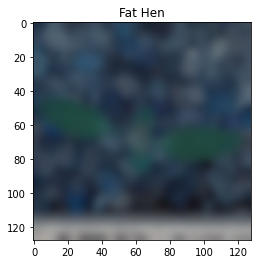

In [ ]:
# see image #2000 after gaussian blur

ind = 2000

plt.imshow(X[ind]);
plt.title(y_label.iloc[ind][0]);

### Making Data Model Ready

##### 3.b. Reshape data into shapes compatible with Keras models.
- Data is already is Keras compatible model

In [9]:
# Convert labels to one hot vectors.

lbin = LabelBinarizer()
y = lbin.fit_transform(y)

In [10]:
# Check y value after one hot vector

y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [11]:
# Split the data into training, validation and test set in the ratio of 60:15:25 respectively

seed = 5

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, shuffle=True, random_state=seed)

X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.2, shuffle=True, random_state=seed)

In [80]:
# Print the label for y_train[0].

print(lbin.inverse_transform(y_train)[0],' : ',y_train[0])

Scentless Mayweed  :  [0 0 0 0 0 0 0 0 1 0 0 0]


## Building Model and training

In [79]:
# Defining model

model = Sequential()
model.add(Conv2D(512, (5, 5), padding='same', activation="relu", input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, (5, 5), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(GlobalMaxPooling2D())

model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(12, activation="softmax"))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 512)     38912     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 128, 512)     2048      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 512)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 64, 64, 512)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 256)       3277056   
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 256)       1024      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 256)      

In [81]:
# initiate Adam optimizer
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)


In [82]:
# Model compilation 

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [27]:
#Adding Early stopping callback to the fit function is going to stop the training,
#if the val_loss is not going to change even '0.001' for more than 10 continous epochs

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('cifar_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)
 

Epoch 1/75
90/90 [==============================] - 17s 164ms/step - loss: 2.9046 - accuracy: 0.1411 - val_loss: 2.6212 - val_accuracy: 0.1304
Epoch 2/75
90/90 [==============================] - 13s 148ms/step - loss: 2.1208 - accuracy: 0.2417 - val_loss: 3.9251 - val_accuracy: 0.1304
Epoch 3/75
90/90 [==============================] - 13s 148ms/step - loss: 1.9469 - accuracy: 0.3021 - val_loss: 5.4725 - val_accuracy: 0.1304
Epoch 4/75
90/90 [==============================] - 13s 148ms/step - loss: 1.8457 - accuracy: 0.3454 - val_loss: 3.5942 - val_accuracy: 0.1304
Epoch 5/75
90/90 [==============================] - 13s 148ms/step - loss: 1.6216 - accuracy: 0.4197 - val_loss: 2.1047 - val_accuracy: 0.2482
Epoch 6/75
90/90 [==============================] - 13s 148ms/step - loss: 1.4903 - accuracy: 0.4722 - val_loss: 2.4573 - val_accuracy: 0.2525
Epoch 7/75
90/90 [==============================] - 13s 148ms/step - loss: 1.4406 - accuracy: 0.5030 - val_loss: 1.7778 - val_accuracy: 0.3268

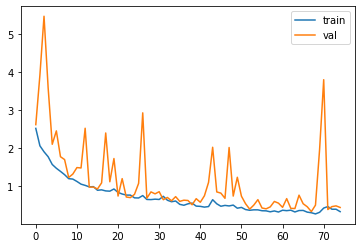

In [83]:
# Training model

epochs =75
batch_size = 32

history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data= (X_val, y_val),
                    validation_batch_size= batch_size,
                    shuffle=True,
                    verbose=1
                    )

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [84]:
# Crating history dataframe and saving to csv for future retrival

hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.to_csv(data_path+'/hist.csv')

In [ ]:
# retrieve history as needed

hist = pd.read_csv(data_path+'/hist.csv', index_col=0)

hist

,loss,accuracy,val_loss,val_accuracy,epoch
0,2.580233,0.137592,2.634721,0.130435,0
1,2.123406,0.263601,3.935491,0.130435,1
2,1.807386,0.361881,3.522314,0.130435,2
3,1.687053,0.399438,5.296919,0.130435,3
4,1.571661,0.451386,3.054000,0.133240,4
...,...,...,...,...,...
70,0.269005,0.908038,0.532581,0.819074,70
71,0.252473,0.914356,0.505310,0.835905,71
72,0.267423,0.906634,0.355938,0.890603,72
73,0.251262,0.912952,0.667980,0.812062,73


In [ ]:
# Save model and weights

model.save(data_path+'/model.h5')     
model.save_weights(data_path+'/model_weights.h5')

In [ ]:
# Load the pre trained model from the HDF5 file saved previously

model = load_model(data_path+'/model.h5')
model.load_weights(data_path+'/model_weights.h5')

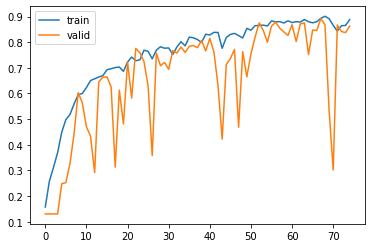

In [86]:
# Checking accuracy

plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.legend(("train" , "valid") , loc =0);

In [87]:
# Performance on test data

model.evaluate(X_test, y_test)

38/38 [==============================] - 2s 54ms/step - loss: 0.4515 - accuracy: 0.8695


[0.45147931575775146, 0.869528591632843]

In [88]:
#predicting target variable

y_predict = np.argmax(model.predict(X_test), axis=-1)


In [89]:
# Converting y_test to numbers

y_test_label_code = np.argmax(y_test, axis=-1)

y_test_label_code

array([4, 6, 8, ..., 3, 1, 9])

In [90]:
# Building a target dataframe with test and predict values

target_df = pd.DataFrame()

target_df['y_test_label'] = lbin.inverse_transform(y_test)
target_df['y_test'] = y_test_label_code
target_df['y_pred'] = y_predict

target_df

,y_test_label,y_test,y_pred
0,Common wheat,4,4
1,Loose Silky-bent,6,6
2,Scentless Mayweed,8,8
3,Fat Hen,5,5
4,Shepherds Purse,9,9
...,...,...,...
1183,Charlock,1,1
1184,Common Chickweed,3,3
1185,Common Chickweed,3,3
1186,Charlock,1,1


In [91]:
# printing different metrices

print('Accuracy Model: '+ str(model.evaluate(X_test,y_test)[1]))
print('Recall_score: ' + str(recall_score(y_test_label_code,y_predict, average='macro')))
print('Precision_score: ' + str(precision_score(y_test_label_code, y_predict, average='macro')))
print('F-score: ' + str(f1_score(y_test_label_code,y_predict, average='macro')))

38/38 [==============================] - 2s 43ms/step - loss: 0.4515 - accuracy: 0.8695
Accuracy Model: 0.869528591632843
Recall_score: 0.82990477147103
Precision_score: 0.8685731111411905
F-score: 0.8336275567590811


In [92]:
# Building dataframe to store all metices

metric_df = target_df[['y_test_label','y_test']]
metric_df.drop_duplicates(keep='first', inplace=True)
metric_df.set_index('y_test',inplace=True)
metric_df.sort_index(inplace=True)
metric_df['Accuracy'] = 0
metric_df['Recall'] = 0
metric_df['Precision'] = 0
metric_df['F-score'] = 0
metric_df

,y_test_label,Accuracy,Recall,Precision,F-score
y_test,,,,,
0,Black-grass,0,0,0,0
1,Charlock,0,0,0,0
2,Cleavers,0,0,0,0
3,Common Chickweed,0,0,0,0
4,Common wheat,0,0,0,0
5,Fat Hen,0,0,0,0
6,Loose Silky-bent,0,0,0,0
7,Maize,0,0,0,0
8,Scentless Mayweed,0,0,0,0


In [93]:
# Updating metic values for different classes

for item in metric_df['y_test_label']:
  y_test_item = target_df[target_df['y_test_label']==item]['y_test']
  y_pred_item = target_df[target_df['y_test_label']==item]['y_pred']
  X_test_item = X_test[list(target_df[target_df['y_test_label']==item].index)]
  y_test_item_orig = y_test[list(target_df[target_df['y_test_label']==item].index)]
  ind = list(metric_df[metric_df['y_test_label']==item].index)
  
  metric_df.at[ind,'Accuracy'] = model.evaluate(X_test_item,y_test_item_orig)[1]
  metric_df.at[ind,'Recall'] = recall_score(y_test_item,y_pred_item, average='micro')
  metric_df.at[ind,'Precision'] = precision_score(y_test_item, y_pred_item, average='micro')
  metric_df.at[ind,'F-score'] = f1_score(y_test_item,y_pred_item, average='micro')

4/4 [==============================] - 1s 233ms/step - loss: 0.4119 - accuracy: 0.8824


In [94]:
# View values 

metric_df

,y_test_label,Accuracy,Recall,Precision,F-score
y_test,,,,,
0,Black-grass,0.266667,0.266667,0.266667,0.266667
1,Charlock,0.820225,0.820225,0.820225,0.820225
2,Cleavers,0.961538,0.961538,0.961538,0.961538
3,Common Chickweed,0.943750,0.943750,0.943750,0.943750
4,Common wheat,0.810811,0.810811,0.810811,0.810811
5,Fat Hen,0.983871,0.983871,0.983871,0.983871
6,Loose Silky-bent,0.970760,0.970760,0.970760,0.970760
7,Maize,0.779661,0.779661,0.779661,0.779661
8,Scentless Mayweed,0.823944,0.823944,0.823944,0.823944


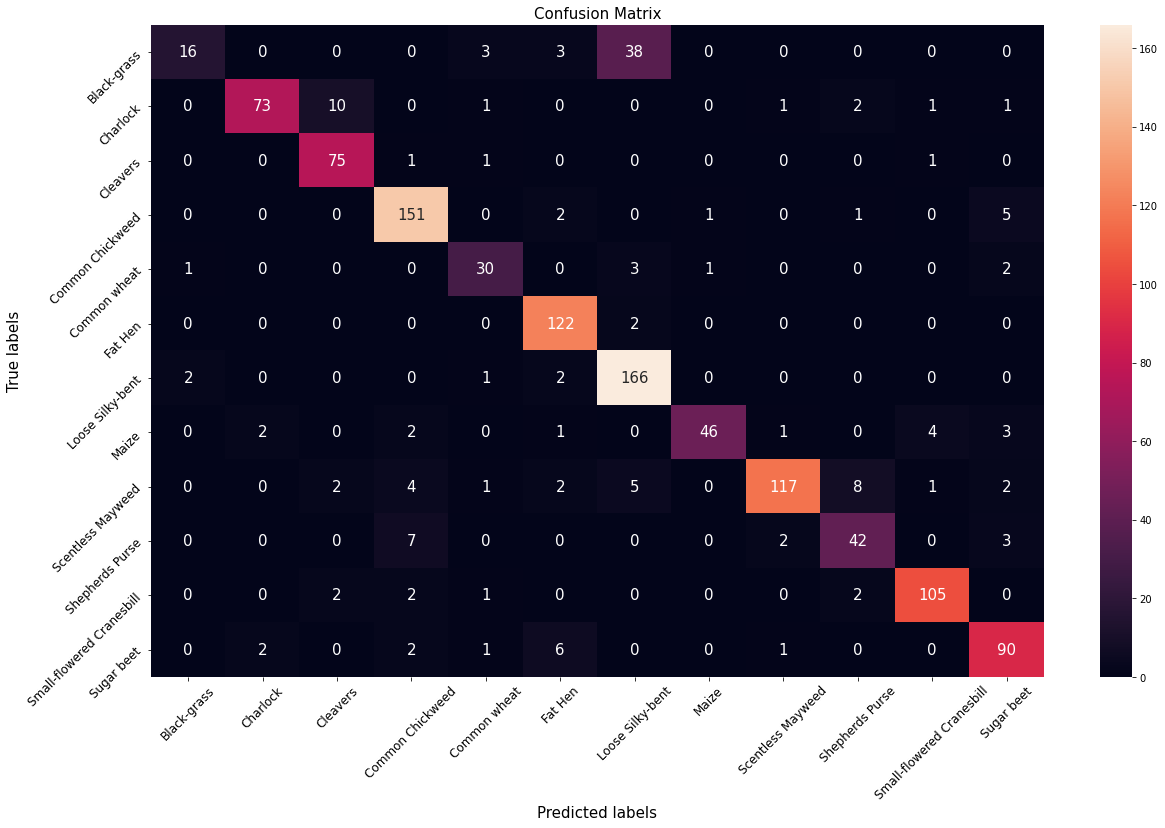

In [95]:
# Confusion metrix

fig, ax = plt.subplots(nrows=1,ncols=1,figsize = (20,12));
sns.heatmap(confusion_matrix(target_df['y_test'],target_df['y_pred']),annot=True,ax = ax,fmt='g',annot_kws={"size": 15});
ax.set_xlabel('Predicted labels',fontsize=15);
ax.set_ylabel('True labels',fontsize=15); 
ax.set_title('Confusion Matrix',fontsize=15);
ax.xaxis.set_ticklabels(list(metric_df['y_test_label']),fontsize=12,rotation = 45); 
ax.yaxis.set_ticklabels(list(metric_df['y_test_label']),fontsize=12,rotation = 45);


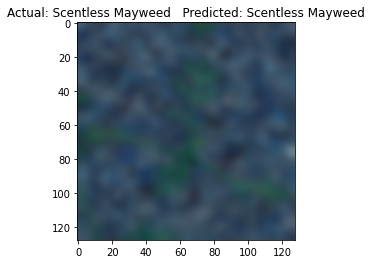

In [96]:
# Visualize predictions for x_test[2]

ind = 2

plt.imshow(X_test[ind]);
plt.title('Actual: ' + lbin.inverse_transform(y_test)[ind] + '   Predicted: ' + lbin.inverse_transform(model.predict(X_test))[ind]);

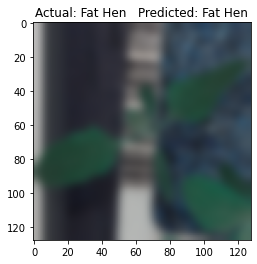

In [97]:
# Visualize predictions for x_test[3]

ind = 3

plt.imshow(X_test[ind]);
plt.title('Actual: ' + lbin.inverse_transform(y_test)[ind] + '   Predicted: ' + lbin.inverse_transform(model.predict(X_test))[ind]);

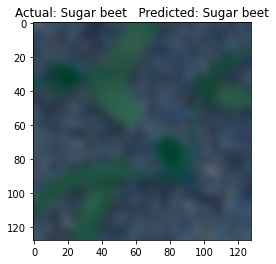

In [98]:
# Visualize predictions for x_test[33]

ind = 33

plt.imshow(X_test[ind]);
plt.title('Actual: ' + lbin.inverse_transform(y_test)[ind] + '   Predicted: ' + lbin.inverse_transform(model.predict(X_test))[ind]);

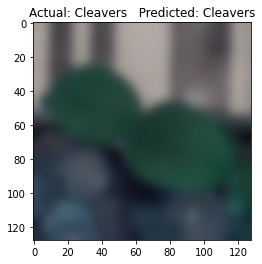

In [99]:
# Visualize predictions for x_test[36]

ind = 36

plt.imshow(X_test[ind]);
plt.title('Actual: ' + lbin.inverse_transform(y_test)[ind] + '   Predicted: ' + lbin.inverse_transform(model.predict(X_test))[ind]);

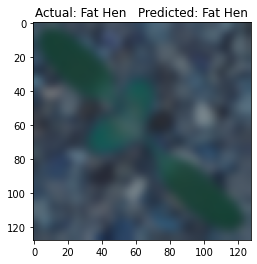

In [100]:
# Visualize predictions for x_test[59]

ind = 59

plt.imshow(X_test[ind]);
plt.title('Actual: ' + lbin.inverse_transform(y_test)[ind] + '   Predicted: ' + lbin.inverse_transform(model.predict(X_test))[ind]);

## <center><font color = 'magenta'>*Additional Section*</font></center>

### HyperParameter Tuning using Hyperband

In [14]:
# Build hypermodel

def build_model(hp):
    model_1 = Sequential() #Start model
    model_1.add(Conv2D(filters=hp.Int('Input_Filters',min_value=32,max_value=512,step=32),  # 1st Convolution Layer connected to Input Layer
                       kernel_size= hp.Choice('Input_Kernel_in', [3,5,7]),
                       padding='same', 
                       activation=hp.Choice('Input_activation', ['relu','tanh','elu']),
                       input_shape=X_train.shape[1:]))
    model_1.add(BatchNormalization())
    model_1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model_1.add(Dropout(hp.Float('Input_dropout', 0, 0.5, step=0.1, default=0.3)))
    for i in range(hp.Int('num_layers', 0, 5)):
      model_1.add(Conv2D(filters=hp.Int('Filters_' +  str(i), min_value=32,max_value=512,step=32),  # 1st Convolution Layer connected to Input Layer
                       kernel_size= hp.Choice('Kernal_' +  str(i), [3,5,7]),
                       padding='same', 
                       activation=hp.Choice('Activation_' +  str(i), ['relu','tanh','elu']))) # Hidden convolution Layer
      model_1.add(BatchNormalization())
      model_1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
      model_1.add(Dropout(hp.Float('Dropout_' +  str(i), 0, 0.5, step=0.1, default=0.3))) # Drop out layer for regularization

    model_1.add(GlobalMaxPooling2D())  # Flattening with MaxPooling feature

    model_1.add(Dense(units=hp.Int('Dense_in',min_value=32,max_value=1024,step=32), 
                      activation = hp.Choice('Activation_dense_in', ['relu', 'tanh','elu']))) # 1st Dense Layer
    model_1.add(Dropout(hp.Float('Densedropout_in', 0, 0.5, step=0.1, default=0.3))) # Drop out layer for regularization

    for i in range(hp.Int('num_layers', 0, 3)):
      model_1.add(Dense(units=hp.Int('Dense_level_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation=hp.Choice('Activation_dense_l_' + str(i), ['relu', 'tanh','elu'])))  # Hidden Layer
      model_1.add(Dropout(hp.Float('Densedropout_l_' + str(i), 0, 0.5, step=0.1, default=0.3))) # Drop out layer for regularization

    model_1.add(Dense(12, activation='softmax')) # Output layer
      
    model_1.compile(
         optimizer=Adam(
             hp.Choice('learning_rate', [0.01, 0.005, 0.001, 0.0005, 0.0001])),
             loss='binary_crossentropy',
             metrics=['accuracy'])
      
    return model_1

In [ ]:
# removing the path if existis

dirpath = Path(data_path, 'Hyperband')
if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)

In [15]:
# define tuner for Hyperband

max_epochs = 100

tunerHB = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=max_epochs,
    seed=5,
    directory=data_path,
    project_name='Hyperband')

INFO:tensorflow:Reloading Oracle from existing project /content/drive/My Drive/UTA/PGPAIML/CNN/SeedPredict/Data/Hyperband/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/My Drive/UTA/PGPAIML/CNN/SeedPredict/Data/Hyperband/tuner0.json


In [ ]:
# serch parameter space

tunerHB.search_space_summary()

Search space summary
Default search space size: 9
Input_Filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
Input_Kernel_in (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5, 7], 'ordered': True}
Input_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu'], 'ordered': False}
Input_dropout (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 5, 'step': 1, 'sampling': None}
Dense_in (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': None}
Activation_dense_in (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu'], 'ordered': False}
Densedropout_in (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (

In [18]:
# Serching best parameter run

batch_size = 32

tunerHB.search(X_train, y_train , batch_size=batch_size, epochs = max_epochs, validation_data =(X_val,y_val), callbacks=[early_stopping,model_checkpoint])

Trial 254 Complete [00h 06m 50s]
val_accuracy: 0.6143057346343994

Best val_accuracy So Far: 0.8387096524238586
Total elapsed time: 04h 54m 04s
INFO:tensorflow:Oracle triggered exit


In [16]:
#Summary of best results

print(tunerHB.results_summary())

Results summary
Results in /content/drive/My Drive/UTA/PGPAIML/CNN/SeedPredict/Data/Hyperband
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
Input_Filters: 160
Input_Kernel_in: 7
Input_activation: tanh
Input_dropout: 0.5
num_layers: 3
Dense_in: 544
Activation_dense_in: relu
Densedropout_in: 0.2
learning_rate: 0.001
Filters_0: 96
Kernal_0: 7
Activation_0: tanh
Dropout_0: 0.1
Filters_1: 512
Kernal_1: 5
Activation_1: elu
Dropout_1: 0.1
Dense_level_0: 352
Activation_dense_l_0: elu
Densedropout_l_0: 0.30000000000000004
Dense_level_1: 352
Activation_dense_l_1: relu
Densedropout_l_1: 0.1
Filters_2: 320
Kernal_2: 3
Activation_2: elu
Dropout_2: 0.2
Filters_3: 192
Kernal_3: 3
Activation_3: relu
Dropout_3: 0.2
Filters_4: 256
Kernal_4: 3
Activation_4: tanh
Dropout_4: 0.0
Dense_level_2: 448
Activation_dense_l_2: elu
Densedropout_l_2: 0.30000000000000004
Dense_level_3: 384
Activation_dense_l_3: tanh
Densedropout_l_3: 0.4
Dense_level_4: 192
Activ

In [17]:
# Best Hyperparameter model using hyperband

print(tunerHB.get_best_hyperparameters()[0].values)

{'Input_Filters': 160, 'Input_Kernel_in': 7, 'Input_activation': 'tanh', 'Input_dropout': 0.5, 'num_layers': 3, 'Dense_in': 544, 'Activation_dense_in': 'relu', 'Densedropout_in': 0.2, 'learning_rate': 0.001, 'Filters_0': 96, 'Kernal_0': 7, 'Activation_0': 'tanh', 'Dropout_0': 0.1, 'Filters_1': 512, 'Kernal_1': 5, 'Activation_1': 'elu', 'Dropout_1': 0.1, 'Dense_level_0': 352, 'Activation_dense_l_0': 'elu', 'Densedropout_l_0': 0.30000000000000004, 'Dense_level_1': 352, 'Activation_dense_l_1': 'relu', 'Densedropout_l_1': 0.1, 'Filters_2': 320, 'Kernal_2': 3, 'Activation_2': 'elu', 'Dropout_2': 0.2, 'Filters_3': 192, 'Kernal_3': 3, 'Activation_3': 'relu', 'Dropout_3': 0.2, 'Filters_4': 256, 'Kernal_4': 3, 'Activation_4': 'tanh', 'Dropout_4': 0.0, 'Dense_level_2': 448, 'Activation_dense_l_2': 'elu', 'Densedropout_l_2': 0.30000000000000004, 'Dense_level_3': 384, 'Activation_dense_l_3': 'tanh', 'Densedropout_l_3': 0.4, 'Dense_level_4': 192, 'Activation_dense_l_4': 'relu', 'Densedropout_l_4': 

In [18]:
# get best model config through hyperband search

print(tunerHB.get_best_models()[0].summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 160)     23680     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 160)     640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 160)       0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 160)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 96)        752736    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 96)        384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 96)        0

In [20]:
# Run test data against best Hyperparametrized Model
best_model = tunerHB.get_best_models(num_models=1)[0]
results = best_model.evaluate(X_test, y_test)

38/38 [==============================] - 1s 27ms/step - loss: 0.0731 - accuracy: 0.8314


<font color='green'>**Observation:** </font>
- Hyper parameter tuning does not give us any such improvement over base model results, but this is probaly more generelized model whereas base model looks somewhat biased to certain categories.

### Transfer Learning

In [42]:
# Import DenseNet201 model

from tensorflow.keras.applications import DenseNet201

In [43]:
# Define model

base_model = DenseNet201(include_top=False, weights='imagenet',input_shape=X_train.shape[1:], pooling='max') 
base_model.trainable = False
transfer_model = Sequential()
transfer_model.add(base_model)
transfer_model.add(Dense(1024,activation=('relu'),kernel_initializer='random_normal', bias_initializer='zeros'))
transfer_model.add(Dropout(0.3))
transfer_model.add(Dense(512,activation=('relu'),kernel_initializer='random_normal', bias_initializer='zeros'))
transfer_model.add(Dropout(0.4))
transfer_model.add(Dense(128,activation=('relu'),kernel_initializer='random_normal', bias_initializer='zeros'))
transfer_model.add(Dropout(0.3))
transfer_model.add(Dense(64,activation=('relu'),kernel_initializer='random_normal', bias_initializer='zeros'))
transfer_model.add(Dropout(0.4))
transfer_model.add(Dense(12,activation=('softmax')))
transfer_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              1967104   
_________________________________________________________________
dropout_23 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_24 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)              

In [44]:
# Compile model

transfer_model.compile(loss='categorical_crossentropy',
                       optimizer=opt,
                       metrics=['accuracy'])

In [45]:
# Training transfer model

epochs =100
batch_size = 32

transfer_history = transfer_model.fit(X_train,
                                      y_train,
                                      batch_size=batch_size,
                                      epochs=epochs,
                                      validation_data=(X_val,y_val),
                                      shuffle=True,
                                      verbose=1
                                      ,callbacks=[early_stopping,model_checkpoint]
                                      )

Epoch 1/100
90/90 [==============================] - 16s 78ms/step - loss: 2.9099 - accuracy: 0.0918 - val_loss: 2.4492 - val_accuracy: 0.1304

Epoch 00001: val_loss did not improve from 1.04143
Epoch 2/100
90/90 [==============================] - 4s 49ms/step - loss: 2.4510 - accuracy: 0.1309 - val_loss: 2.4358 - val_accuracy: 0.1304

Epoch 00002: val_loss did not improve from 1.04143
Epoch 3/100
90/90 [==============================] - 4s 50ms/step - loss: 2.4284 - accuracy: 0.1426 - val_loss: 2.3341 - val_accuracy: 0.2034

Epoch 00003: val_loss did not improve from 1.04143
Epoch 4/100
90/90 [==============================] - 4s 49ms/step - loss: 2.3304 - accuracy: 0.1835 - val_loss: 2.0419 - val_accuracy: 0.2833

Epoch 00004: val_loss did not improve from 1.04143
Epoch 5/100
90/90 [==============================] - 4s 49ms/step - loss: 2.1367 - accuracy: 0.2312 - val_loss: 1.9102 - val_accuracy: 0.2889

Epoch 00005: val_loss did not improve from 1.04143
Epoch 6/100
90/90 [==========

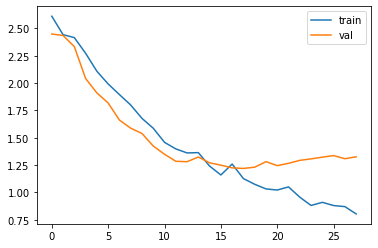

In [46]:
# plot training history

transfer_hist  = pd.DataFrame(transfer_history.history)
transfer_hist['epoch'] = transfer_history.epoch

plt.plot(transfer_hist['loss'], label='train')
plt.plot(transfer_hist['val_loss'], label='val')
plt.legend()
plt.show()

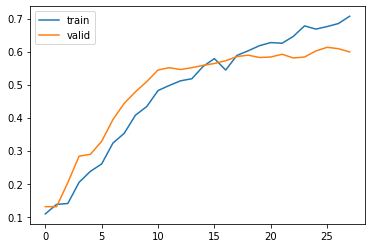

In [47]:
# Checking accuracy

plt.plot(transfer_hist['accuracy'])
plt.plot(transfer_hist['val_accuracy'])
plt.legend(("train" , "valid") , loc =0)

In [48]:
# Transfer model performance on test data

transfer_model.evaluate(X_test, y_test)

38/38 [==============================] - 1s 38ms/step - loss: 1.3339 - accuracy: 0.6027


[1.3339449167251587, 0.6026936173439026]

In [52]:
# Build hypermodel for transfer learning

def build_transfer_model(hp):
  base_model = DenseNet201(include_top=False, weights='imagenet',input_shape=X_train.shape[1:], pooling='max')
  base_model.trainable = False
  model_1 = Sequential()
  model_1.add(base_model)

  model_1.add(Dense(units=hp.Int('Dense_in',min_value=32,max_value=1024,step=32),
                    activation = hp.Choice('Activation_dense_in', ['relu', 'tanh','elu']),
                    kernel_initializer='random_normal',
                    bias_initializer='zeros')) # 1st Dense Layer
  model_1.add(Dropout(hp.Float('Densedropout_in', 0, 0.5, step=0.1, default=0.3))) # Drop out layer for regularization

  for i in range(hp.Int('num_layers', 0, 4)):
    model_1.add(Dense(units=hp.Int('Dense_level_' + str(i), min_value=32, max_value=512, step=32), 
                      activation=hp.Choice('Activation_dense_l_' + str(i), ['relu', 'tanh','elu']),
                      kernel_initializer='random_normal',
                      bias_initializer='zeros'))  # Hidden Layer
    model_1.add(Dropout(hp.Float('Densedropout_l_' + str(i), 0, 0.5, step=0.1, default=0.3))) # Drop out layer for regularization

  model_1.add(Dense(12, activation='softmax')) # Output layer
      
  model_1.compile(
      optimizer=Adam(
          hp.Choice('learning_rate', [0.01, 0.005, 0.001, 0.0005, 0.0001])),
          loss='binary_crossentropy',
          metrics=['accuracy'])
  
  return model_1

In [53]:
# removing the path if existis

dirpath = Path(data_path, 'Transfer_Hyperband')
if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)

In [54]:
# define tuner for Transfer Hyperband

max_epochs = 100

tunerTransferHB = Hyperband(
    build_transfer_model,
    objective='val_accuracy',
    max_epochs=max_epochs,
    seed=5,
    directory=data_path,
    project_name='Transfer_Hyperband')

In [55]:
# serch parameter space

tunerTransferHB.search_space_summary()

Search space summary
Default search space size: 5
Dense_in (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': None}
Activation_dense_in (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu'], 'ordered': False}
Densedropout_in (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 4, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.005, 0.001, 0.0005, 0.0001], 'ordered': True}


In [57]:
# Serching best parameter run

batch_size = 32

tunerTransferHB.search(X_train, y_train , batch_size=batch_size, epochs = max_epochs, validation_data =(X_val,y_val))

Trial 255 Complete [00h 08m 22s]
val_accuracy: 0.6886395215988159

Best val_accuracy So Far: 0.695652186870575
Total elapsed time: 04h 51m 18s
INFO:tensorflow:Oracle triggered exit


In [58]:
#Summary of best results

print(tunerTransferHB.results_summary())

Results summary
Results in /content/drive/My Drive/UTA/PGPAIML/CNN/SeedPredict/Data/Transfer_Hyperband
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
Dense_in: 704
Activation_dense_in: relu
Densedropout_in: 0.2
num_layers: 1
learning_rate: 0.0005
Dense_level_0: 224
Activation_dense_l_0: tanh
Densedropout_l_0: 0.2
Dense_level_1: 448
Activation_dense_l_1: relu
Densedropout_l_1: 0.2
Dense_level_2: 480
Activation_dense_l_2: relu
Densedropout_l_2: 0.4
Dense_level_3: 448
Activation_dense_l_3: elu
Densedropout_l_3: 0.4
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 330e19d1b59d9903c48ad7a0c564ccce
Score: 0.695652186870575
Trial summary
Hyperparameters:
Dense_in: 928
Activation_dense_in: elu
Densedropout_in: 0.30000000000000004
num_layers: 1
learning_rate: 0.001
Dense_level_0: 256
Activation_dense_l_0: tanh
Densedropout_l_0: 0.30000000000000004
Dense_level_1: 480
Activation_dense_l_1: elu
Densedro

In [59]:
# Best Hyperparameter model using hyperband

print(tunerTransferHB.get_best_hyperparameters()[0].values)

{'Dense_in': 704, 'Activation_dense_in': 'relu', 'Densedropout_in': 0.2, 'num_layers': 1, 'learning_rate': 0.0005, 'Dense_level_0': 224, 'Activation_dense_l_0': 'tanh', 'Densedropout_l_0': 0.2, 'Dense_level_1': 448, 'Activation_dense_l_1': 'relu', 'Densedropout_l_1': 0.2, 'Dense_level_2': 480, 'Activation_dense_l_2': 'relu', 'Densedropout_l_2': 0.4, 'Dense_level_3': 448, 'Activation_dense_l_3': 'elu', 'Densedropout_l_3': 0.4, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '330e19d1b59d9903c48ad7a0c564ccce'}


In [60]:
# get best model config through hyperband search

print(tunerTransferHB.get_best_models()[0].summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
dense (Dense)                (None, 704)               1352384   
_________________________________________________________________
dropout (Dropout)            (None, 704)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 224)               157920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 224)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                2700      
Total params: 19,834,988
Trainable params: 1,513,004
Non-trainable params: 18,321,984
____________________________________

In [61]:
# Run test data against best Hyperparametrized Model
best_Transfer_model = tunerTransferHB.get_best_models(num_models=1)[0]
results = best_Transfer_model.evaluate(X_test, y_test)

38/38 [==============================] - 6s 39ms/step - loss: 0.2486 - accuracy: 0.6582


<font color='green'>**Observation:** </font>
- Out of Hyperband model, Trnsfer lerning model and Trnsfer Learning hyperband tuned model,  1st Hyperband model gives the best result. So we will generate the results once more using best model

In [62]:
# Best model so far is

print(tunerHB.get_best_hyperparameters()[0].values)

{'Input_Filters': 160, 'Input_Kernel_in': 7, 'Input_activation': 'tanh', 'Input_dropout': 0.5, 'num_layers': 3, 'Dense_in': 544, 'Activation_dense_in': 'relu', 'Densedropout_in': 0.2, 'learning_rate': 0.001, 'Filters_0': 96, 'Kernal_0': 7, 'Activation_0': 'tanh', 'Dropout_0': 0.1, 'Filters_1': 512, 'Kernal_1': 5, 'Activation_1': 'elu', 'Dropout_1': 0.1, 'Dense_level_0': 352, 'Activation_dense_l_0': 'elu', 'Densedropout_l_0': 0.30000000000000004, 'Dense_level_1': 352, 'Activation_dense_l_1': 'relu', 'Densedropout_l_1': 0.1, 'Filters_2': 320, 'Kernal_2': 3, 'Activation_2': 'elu', 'Dropout_2': 0.2, 'Filters_3': 192, 'Kernal_3': 3, 'Activation_3': 'relu', 'Dropout_3': 0.2, 'Filters_4': 256, 'Kernal_4': 3, 'Activation_4': 'tanh', 'Dropout_4': 0.0, 'Dense_level_2': 448, 'Activation_dense_l_2': 'elu', 'Densedropout_l_2': 0.30000000000000004, 'Dense_level_3': 384, 'Activation_dense_l_3': 'tanh', 'Densedropout_l_3': 0.4, 'Dense_level_4': 192, 'Activation_dense_l_4': 'relu', 'Densedropout_l_4': 

In [63]:
# Best model config

print(tunerHB.get_best_models()[0].summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 160)     23680     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 160)     640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 160)       0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 160)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 96)        752736    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 96)        384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 96)        0

In [65]:
#predicting target variable

y_predict_HB = np.argmax(best_model.predict(X_test), axis=-1)

In [66]:
# Converting y_test to numbers

y_test_label_code_HB = np.argmax(y_test, axis=-1)

y_test_label_code_HB

array([4, 6, 8, ..., 3, 1, 9])

In [67]:
# Building a target dataframe with test and predict values

target_df_HB = pd.DataFrame()

target_df_HB['y_test_label'] = lbin.inverse_transform(y_test)
target_df_HB['y_test'] = y_test_label_code_HB
target_df_HB['y_pred'] = y_predict_HB

target_df_HB

,y_test_label,y_test,y_pred
0,Common wheat,4,4
1,Loose Silky-bent,6,6
2,Scentless Mayweed,8,8
3,Fat Hen,5,5
4,Shepherds Purse,9,3
...,...,...,...
1183,Charlock,1,1
1184,Common Chickweed,3,3
1185,Common Chickweed,3,3
1186,Charlock,1,1


In [68]:
# printing different metrices

print('Accuracy Model: '+ str(best_model.evaluate(X_test,y_test)[1]))
print('Recall_score: ' + str(recall_score(y_test_label_code_HB,y_predict_HB, average='macro')))
print('Precision_score: ' + str(precision_score(y_test_label_code_HB, y_predict_HB, average='macro')))
print('F-score: ' + str(f1_score(y_test_label_code_HB,y_predict_HB, average='macro')))

38/38 [==============================] - 1s 26ms/step - loss: 0.0748 - accuracy: 0.8241
Accuracy Model: 0.8240740895271301
Recall_score: 0.7825765467303745
Precision_score: 0.8267428641958371
F-score: 0.7945035615484587


In [69]:
# Building dataframe to store all metices

metric_df_HB = target_df_HB[['y_test_label','y_test']]
metric_df_HB.drop_duplicates(keep='first', inplace=True)
metric_df_HB.set_index('y_test',inplace=True)
metric_df_HB.sort_index(inplace=True)
metric_df_HB['Accuracy'] = 0
metric_df_HB['Recall'] = 0
metric_df_HB['Precision'] = 0
metric_df_HB['F-score'] = 0
metric_df_HB

,y_test_label,Accuracy,Recall,Precision,F-score
y_test,,,,,
0,Black-grass,0,0,0,0
1,Charlock,0,0,0,0
2,Cleavers,0,0,0,0
3,Common Chickweed,0,0,0,0
4,Common wheat,0,0,0,0
5,Fat Hen,0,0,0,0
6,Loose Silky-bent,0,0,0,0
7,Maize,0,0,0,0
8,Scentless Mayweed,0,0,0,0


In [70]:
# Updating metic values for different classes

for item in metric_df_HB['y_test_label']:
  y_test_item = target_df_HB[target_df_HB['y_test_label']==item]['y_test']
  y_pred_item = target_df_HB[target_df_HB['y_test_label']==item]['y_pred']
  X_test_item = X_test[list(target_df_HB[target_df_HB['y_test_label']==item].index)]
  y_test_item_orig = y_test[list(target_df_HB[target_df_HB['y_test_label']==item].index)]
  ind = list(metric_df_HB[metric_df_HB['y_test_label']==item].index)
  
  metric_df_HB.at[ind,'Accuracy'] = best_model.evaluate(X_test_item,y_test_item_orig)[1]
  metric_df_HB.at[ind,'Recall'] = recall_score(y_test_item,y_pred_item, average='micro')
  metric_df_HB.at[ind,'Precision'] = precision_score(y_test_item, y_pred_item, average='micro')
  metric_df_HB.at[ind,'F-score'] = f1_score(y_test_item,y_pred_item, average='micro')

4/4 [==============================] - 0s 57ms/step - loss: 0.0759 - accuracy: 0.8529


In [71]:
# View values 

metric_df_HB

,y_test_label,Accuracy,Recall,Precision,F-score
y_test,,,,,
0,Black-grass,0.566667,0.566667,0.566667,0.566667
1,Charlock,0.943820,0.943820,0.943820,0.943820
2,Cleavers,0.666667,0.666667,0.666667,0.666667
3,Common Chickweed,0.962500,0.962500,0.962500,0.962500
4,Common wheat,0.702703,0.702703,0.702703,0.702703
5,Fat Hen,0.862903,0.862903,0.862903,0.862903
6,Loose Silky-bent,0.812865,0.812865,0.812865,0.812865
7,Maize,0.796610,0.796610,0.796610,0.796610
8,Scentless Mayweed,0.859155,0.859155,0.859155,0.859155


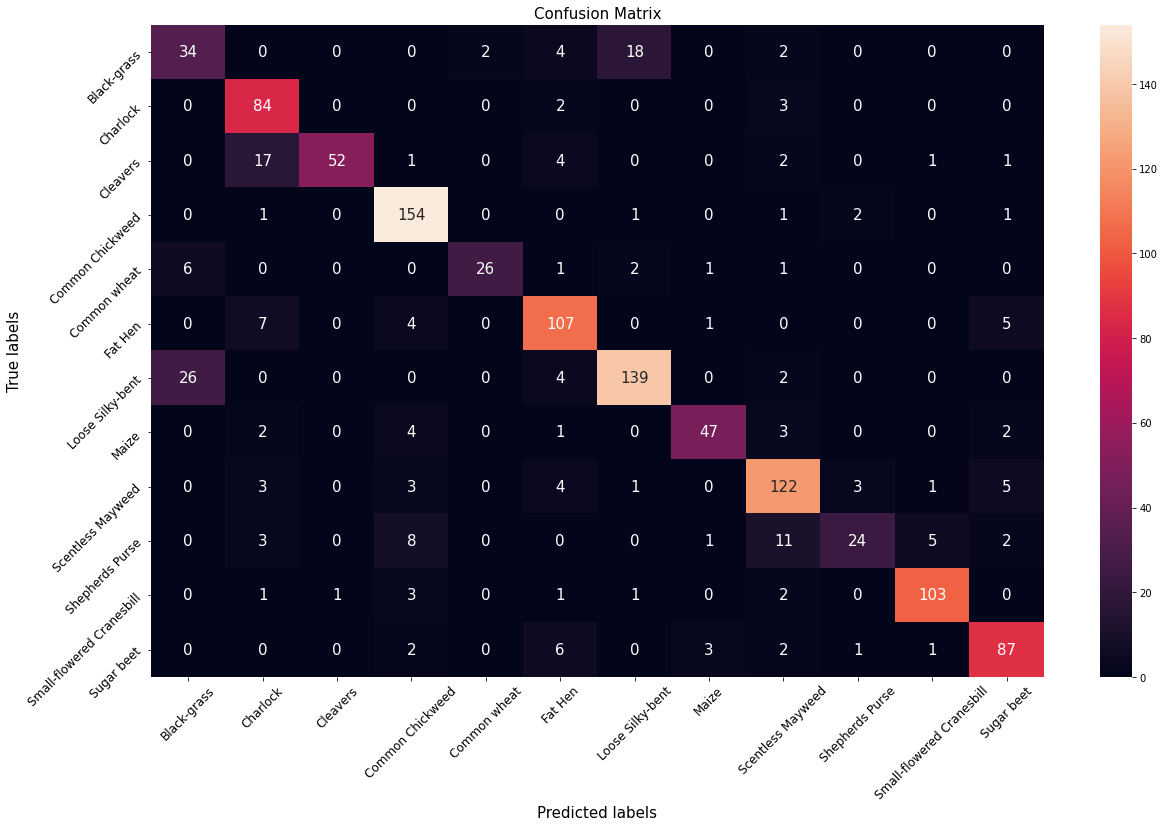

In [72]:
# Confusion metrix

fig, ax = plt.subplots(nrows=1,ncols=1,figsize = (20,12));
sns.heatmap(confusion_matrix(target_df_HB['y_test'],target_df_HB['y_pred']),annot=True,ax = ax,fmt='g',annot_kws={"size": 15});
ax.set_xlabel('Predicted labels',fontsize=15);
ax.set_ylabel('True labels',fontsize=15); 
ax.set_title('Confusion Matrix',fontsize=15);
ax.xaxis.set_ticklabels(list(metric_df_HB['y_test_label']),fontsize=12,rotation = 45); 
ax.yaxis.set_ticklabels(list(metric_df_HB['y_test_label']),fontsize=12,rotation = 45);

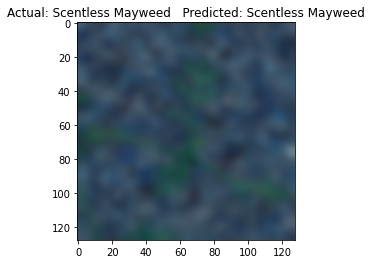

In [73]:
# Visualize predictions for x_test[2]

ind = 2

plt.imshow(X_test[ind]);
plt.title('Actual: ' + lbin.inverse_transform(y_test)[ind] + '   Predicted: ' + lbin.inverse_transform(best_model.predict(X_test))[ind]);

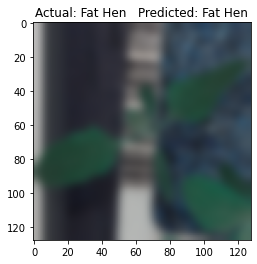

In [74]:
# Visualize predictions for x_test[3]

ind = 3

plt.imshow(X_test[ind]);
plt.title('Actual: ' + lbin.inverse_transform(y_test)[ind] + '   Predicted: ' + lbin.inverse_transform(best_model.predict(X_test))[ind]);

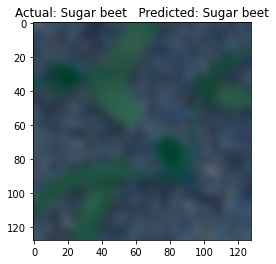

In [75]:
# Visualize predictions for x_test[33]

ind = 33

plt.imshow(X_test[ind]);
plt.title('Actual: ' + lbin.inverse_transform(y_test)[ind] + '   Predicted: ' + lbin.inverse_transform(best_model.predict(X_test))[ind]);

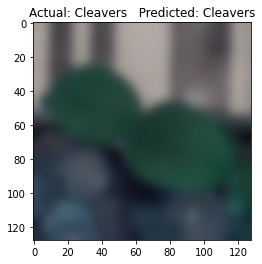

In [76]:
# Visualize predictions for x_test[36]

ind = 36

plt.imshow(X_test[ind]);
plt.title('Actual: ' + lbin.inverse_transform(y_test)[ind] + '   Predicted: ' + lbin.inverse_transform(best_model.predict(X_test))[ind]);

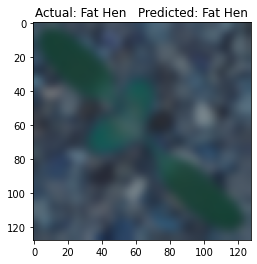

In [77]:
# Visualize predictions for x_test[59]

ind = 59

plt.imshow(X_test[ind]);
plt.title('Actual: ' + lbin.inverse_transform(y_test)[ind] + '   Predicted: ' + lbin.inverse_transform(best_model.predict(X_test))[ind]);